# Mountain (Python)

In [1]:
from random import random

import fastscapelib as fs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Theme that looks reasonably fine on both dark/light modes
matplotlib.style.use('Solarize_Light2')
matplotlib.rcParams['axes.grid'] = False

## Setup the Grid, Flow Graph and Eroders

In [2]:
bs = fs.RasterBoundaryStatus(fs.NodeStatus.FIXED_VALUE_BOUNDARY)
grid = fs.RasterGrid.from_length([301, 301], [7.5e4, 7.5e4], bs, [])

In [3]:
flow_graph = fs.FlowGraph(grid, [fs.SingleFlowRouter(), fs.MSTSinkResolver()])

In [4]:
spl_eroder = fs.SPLEroder(
    flow_graph,
    k_coef=2e-4,
    area_exp=0.4,
    slope_exp=1,
    tolerance=1e-5
)

diffusion_eroder = fs.DiffusionADIEroder(grid, 0.01)

## Setup Initial Conditions and External Forcing

In [5]:
rng = np.random.Generator(np.random.PCG64(1234))

init_elevation = rng.uniform(0, 1, size=grid.shape)

elevation = init_elevation
drainage_area = np.empty_like(elevation)

In [6]:
uplift_rate = np.full_like(elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.
uplift_rate[:, [0, -1]] = 0.

## Run the Model

In [7]:
dt = 2e4
nsteps = 50

for step in range(nsteps):
    # uplift (no uplift at fixed elevation boundaries)
    uplifted_elevation = elevation + dt * uplift_rate
    
    # flow routing
    filled_elevation = flow_graph.update_routes(uplifted_elevation)
    
    # flow accumulation (drainage area)
    flow_graph.accumulate(drainage_area, 1.0)
    
    # apply channel erosion then hillslope diffusion
    spl_erosion = spl_eroder.erode(uplifted_elevation, drainage_area, dt)
    diff_erosion = diffusion_eroder.erode(uplifted_elevation - spl_erosion, dt)
    
    # update topography
    elevation = uplifted_elevation - spl_erosion - diff_erosion


## Plot outputs and other diagnostics


- Topographic elevation

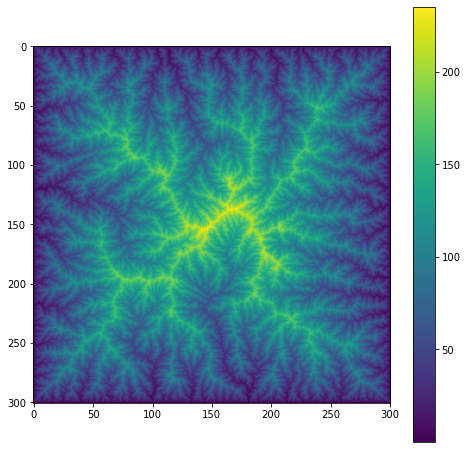

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(elevation)
plt.colorbar();

- Drainage area (log)

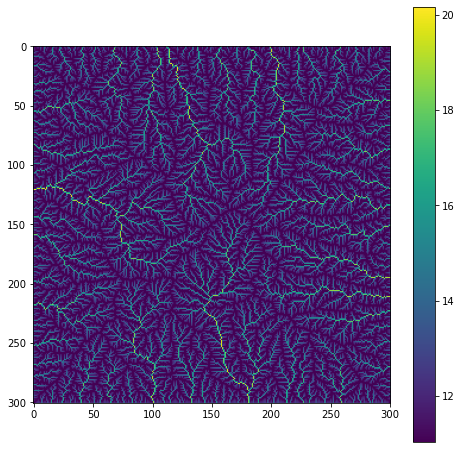

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.log(drainage_area))
plt.colorbar();

- Drainage basins

In [10]:
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
rnd_cm = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

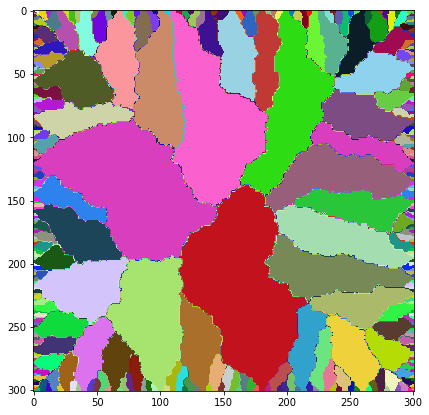

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(flow_graph.basins(), cmap=rnd_cm);